# Exemples d'utilisation du package opera-python

## Datasets

Pour ces exemples, on va réutiliser les mêmes données que celles utilisées dans la vignette d'opéra R (lien ci-dessous). Les experts considérés représentent les prédictions de charge électrique en France obtenues avec trois méthodes différentes :

1. Generalized additive model (GAM)
1. Autoregressive short-term correction (AR)
1. Gradient boosting model (GBM)

Les données sont fournies avec ce notebook dans les fichiers "targets.csv" et "experts.csv". 
Lien vignette opera R : https://cran.r-project.org/web/packages/opera/vignettes/opera-vignette.html


In [43]:
import pandas as pd
targets = pd.read_csv("data/targets.csv")["x"]
experts = pd.read_csv("data/experts.csv")

experts.head()

,gam.forecast,ar.forecast,gbm.forecast
0,63982.047608,64963.519035,65622.361441
1,62583.692922,59589.309385,61979.897472
2,63458.386380,63726.074481,64407.397475
3,61069.536947,59607.682635,61228.839243
4,67873.705594,68493.230339,67335.263754


## (TODO) TROUVER UN TITRE A CETTE SOUS SECTION

### Utilisation simple
Le premier exemple concerne le cas d'utilisation le plus basique. On instancie un modèle (BOA dans notre exemple) sur les 100 premières données du dataset. Avec la fonction de coût prédéfinie "mse".


In [46]:
from opera.mixture import Mixture


mod_1 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    model="BOA",
    loss_type="mse",
)
print("Les poids des experts du modèle basique est : ", mod_1.w)

Les poids des experts à la fin est :  [0.76757951 0.15823262 0.07418788]


### Utilisation en deux temps (avec update)

Les résultats précédents peuvent être obtenus en deux temps. On instancie le modèle sur une partie des données et on utilise ensuite la fonction update pour mettre à jour le modèle avec les données restantes.

In [52]:
mod_2 = Mixture(
    y=targets.iloc[0:50],
    experts=experts.iloc[0:50],
    model="BOA",
    loss_type="mse",
)

mod_2.update(new_experts=experts.iloc[50:100], new_y=targets.iloc[50:100])
print("Les poids des experts du modèle avec update est : ", mod_2.w)

Les poids des experts du modèle avec update est :  [0.76757951 0.15823262 0.07418788]


### Predict sur les données restantes 

Pour faire des prédictions sur la base de nouvelles observations en utilisant les derniers coefficients, on utilise la fonction predict.

In [54]:
pred_mod_1 = mod_1.predict(new_experts=experts.iloc[100:])
pred_mod_2 = mod_2.predict(new_experts=experts.iloc[100:])
print(pred_mod_1)


[[53897.95319348]
 [53669.92039684]
 [53245.50468166]
 [56843.94869365]
 [56665.94847465]
 [55394.41194656]
 [57145.37934329]
 [61469.77386375]
 [64602.02246122]
 [72513.50369791]
 [67615.27029029]
 [60483.22362262]]


### Utilisation des awakes

Les awakes sont utilisés pour forcer le modèle à ne pas prendre en compte certaines inputs. Par simplicité, dans l'exemple qui suit, on force le modèle à ne pas considérer toutes les inputs de l'experts "ar".

In [31]:
import numpy as np
awake = np.tile(np.array([1, 0, 1]), (experts.shape[0],)).reshape(experts.shape)
awake[-5:]

array([[1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1],
       [1, 0, 1]])

In [30]:
mod_3 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    awake=awake[0:100],
    model=model,
    loss_type="mse",
    loss_gradient=False,
)

mod_3.weights[-5:,]

array([[0.98676555, 0.        , 0.01323445],
       [0.98669619, 0.        , 0.01330381],
       [0.98659552, 0.        , 0.01340448],
       [0.98644853, 0.        , 0.01355147],
       [0.98615837, 0.        , 0.01384163]])

### Utilisation d'une fonction de coût fournie par l'utilisateur

L'utilisateur a la possibilté de spécifier une fonction de coût non implémenté par défaut. Il suffit de lui passer la fonction en paramètre dans "loss_type".

In [57]:
def custom_mse(x, y):
    return np.abs(x - y)


mod_4 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    model="BOA",
    loss_type=custom_mse,
    loss_gradient=False,
)

mod_4.weights[-5:,]

array([[0.91823072, 0.05492458, 0.0268447 ],
       [0.91778207, 0.05486232, 0.02735561],
       [0.91773326, 0.05417136, 0.02809538],
       [0.91571834, 0.05508254, 0.02919912],
       [0.9144574 , 0.05490843, 0.03063417]])

On peut faire pareil si on veut utiliser le gradient

In [58]:
def custom_gradient_mae(x, y):
    return np.sign(x - y)


mod_5 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    model="BOA",
    loss_type=custom_mse,
    loss_gradient=custom_gradient_mae,
)

mod_5.weights[-5:,]

array([[0.74426645, 0.11538228, 0.14035127],
       [0.73768904, 0.11514188, 0.14716908],
       [0.73178791, 0.11369278, 0.15451931],
       [0.72221727, 0.11531329, 0.16246944],
       [0.71018186, 0.11499822, 0.17481992]])

## Cas particulier de l'algorithme FTRL


L'utilisation de l'algorithme FTRL est légèrement différente des autres algorithmes.

### Utilisation basique

Comme pour les autres algorithmes, on peut instancier le modèle en ne spécifiant que les arguments obligatoires. Dans ce cas, les paramètres par défaut seront utilisés par le modèle.

A noter que pour "FTRL", le paramètre "loss_gradient" doit nécessairement être à True.

In [59]:
mod_6 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    model="FTRL",
    loss_type="mse",
    loss_gradient=True, # Attention, loss_gradient doit être à True quand l'algorithme utilisé est FTRL
)

print(mod_6.w)

[0.34241252 0.33314528 0.3244422 ]


Si l'utilisateur veut spécifier des fonctions de coût ou des contraintes personalisées, il faut les spécifier dans l'argument "parameters" lors de l'init.

In [ ]:
N = experts.shape[1]
w0 = np.full(N, 1 / N)
# Fonction de coût
fun_reg = lambda x: sum(x * np.log(x / w0))

# Dérivé de la fonction de coût
fun_reg_grad = lambda x: np.log(x / w0) + 1
constraints = []
# Contraintes d'égalité
eq_constraints = {
    "type": "eq",
    "fun": lambda x: sum(x) - 1,
    "jac": lambda x: np.ones((1, N)),
}
constraints.append(eq_constraints)

# Contraintes d'inégalité
ineq_constraints = {
    "type": "ineq",
    "fun": lambda x: x,
    "jac": lambda x: np.eye(N),
}
constraints.append(ineq_constraints)


parameters = {
    "fun_reg": fun_reg,
    "fun_reg_grad": fun_reg_grad,
    "constraints": constraints,
    "tol": 1e-20,
    "options": {"maxiter": 50},
}
mod_7 = Mixture(
    y=targets.iloc[0:100],
    experts=experts.iloc[0:100],
    model="FTRL",
    loss_type="mse",
    loss_gradient=True,
    parameters=parameters,
)

## Affichage des graphiques

L'affichage des graphiques se fait avec la fonction "plot_mixture". Si aucun argument n'est spécifié, l'affichage se fait avec les paramètres par défaut.

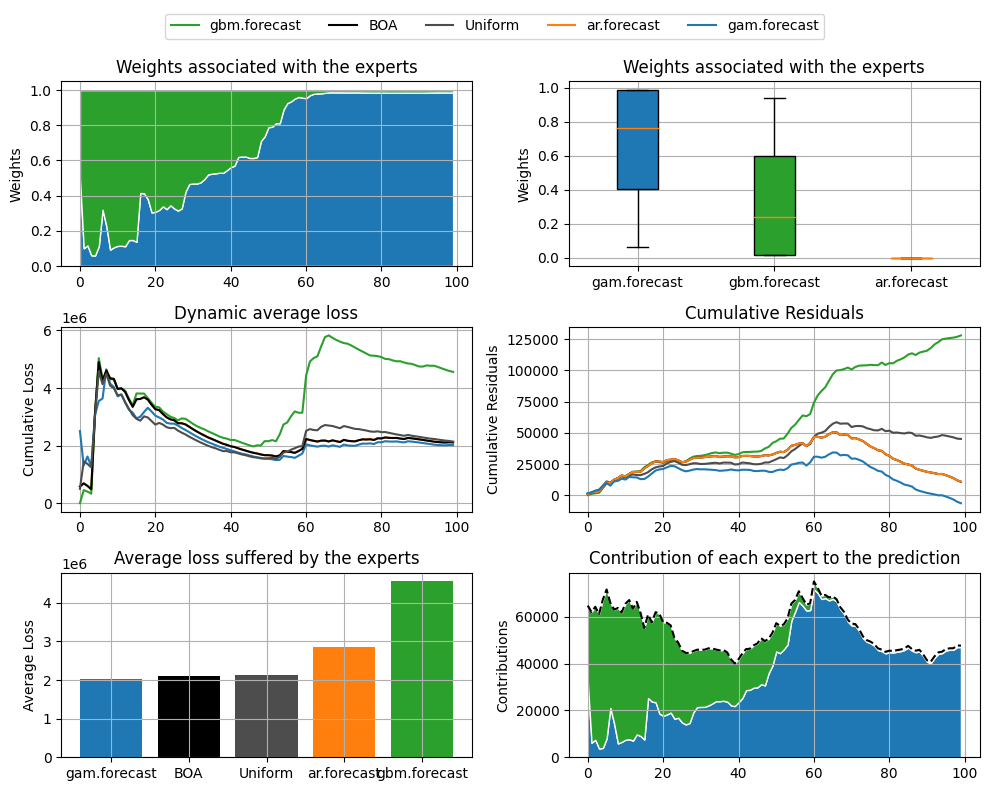

In [32]:
mod_3.plot_mixture()

### Customisation des plots

Avec les différents paramètres, il est possible de personalisé les graphiques affichés.

#### plot avec des couleurs personnalisées

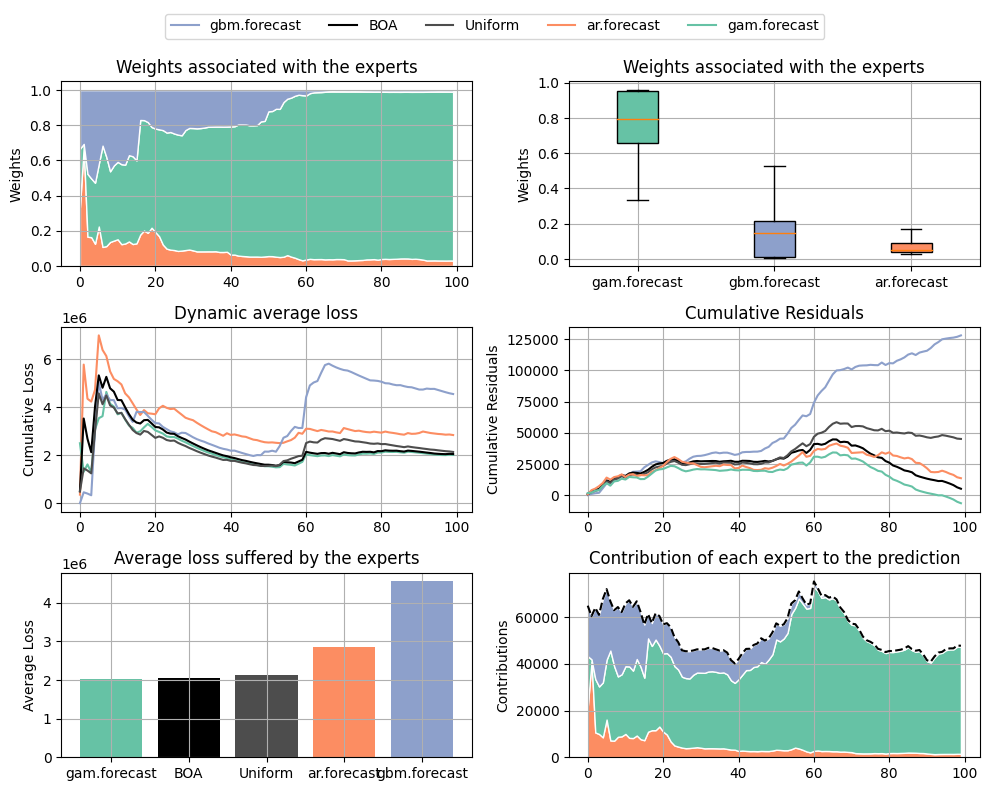

In [12]:
import seaborn as sns
colors = sns.color_palette("Set2", experts.shape[0] + 2)
mod_1.plot_mixture(colors=colors)

#### affichage d'une seule courbe

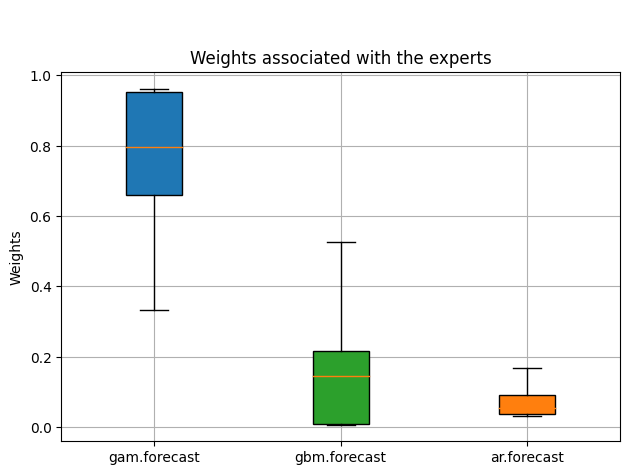

In [13]:

mod_1.plot_mixture(plot_type="boxplot_weight")

# Pour rappel, les options disponibles :
# - plot_weight: Weights associated with the experts
# - boxplot_weight: Weights associated with the experts
# - dyn_avg_loss: Dynamic average loss
# - cumul_res: Cumulative Residuals
# - avg_loss: Average loss suffered by the experts
# - contrib: contibution of each expert to the prediction

#### Affichage des 30 dernière prédictions

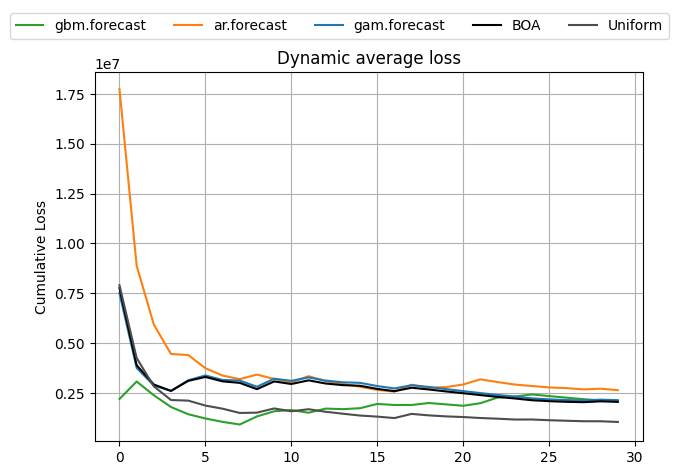

In [14]:
mod_1.plot_mixture(plot_type = "dyn_avg_loss", index_start=-30)


#### Affichage des 20 premières prédictions

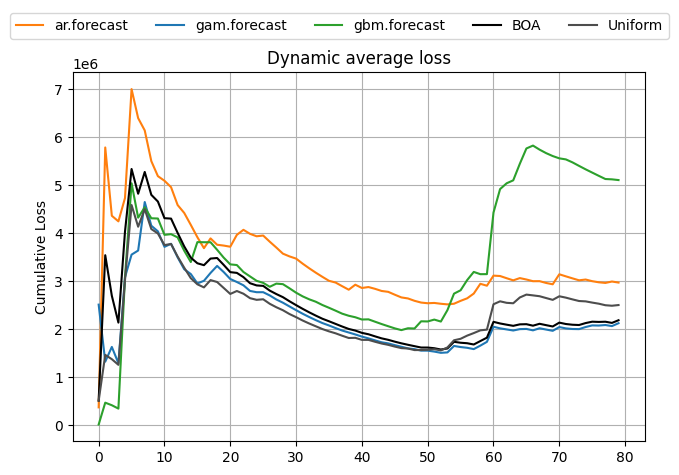

In [15]:
mod_1.plot_mixture(plot_type = "dyn_avg_loss", index_stop=-20)

#### Affichage personalisé

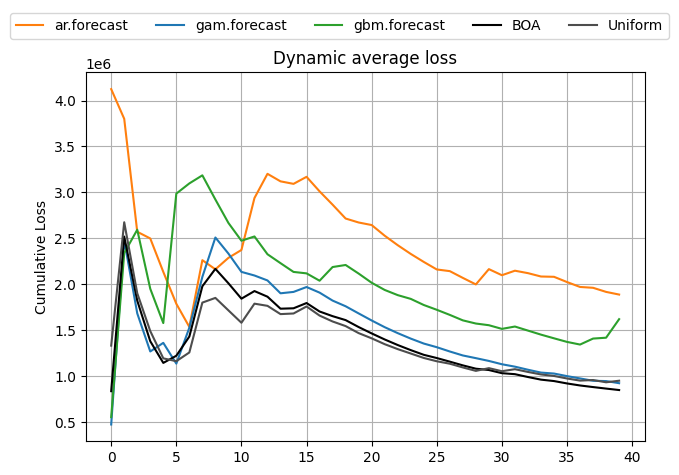

In [16]:
mod_1.plot_mixture(plot_type = "dyn_avg_loss", index_start=10,index_stop=50)

#### Personalisation des titres

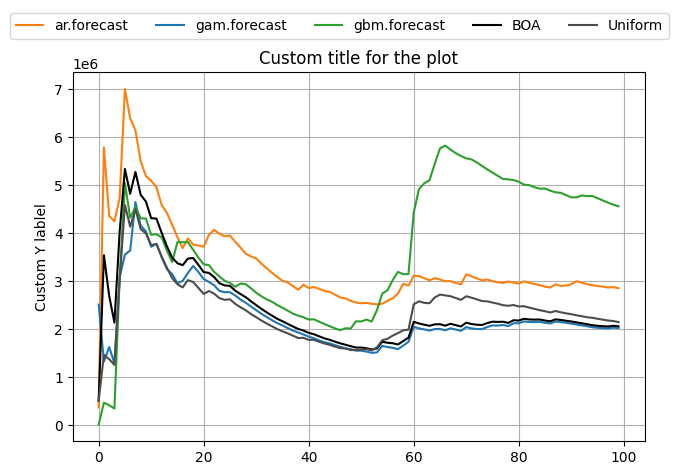

In [17]:
mod_1.plot_mixture(plot_type="dyn_avg_loss", title="Custom title for the plot", ylabel="Custom Y lablel")